In [1]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from ipyexperiments import *
exp1 = IPyExperimentsPytorch()
# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)


*** Experiment started with the Pytorch backend
Device: ID 0, GeForce RTX 2060 (6144 RAM)


*** Current state:
RAM:    Used    Free   Total       Util
CPU:     925  11,211  24,509 MB   3.77% 
GPU:   2,244   3,899   6,144 MB  36.54% 


Random Seed:  999


･ RAM:  △Consumed    △Peaked    Used Total | Exec time 0:00:00.005
･ CPU:          0          0        925 MB |
･ GPU:          0          0      2,245 MB |


In [2]:
# Root directory for dataset
dataroot = "celeba"

# Number of workers for dataloader
workers = 3

# Batch size during training
batch_size = 64

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

･ RAM:  △Consumed    △Peaked    Used Total | Exec time 0:00:00.002
･ CPU:          0          0        925 MB |
･ GPU:          0          0      2,245 MB |


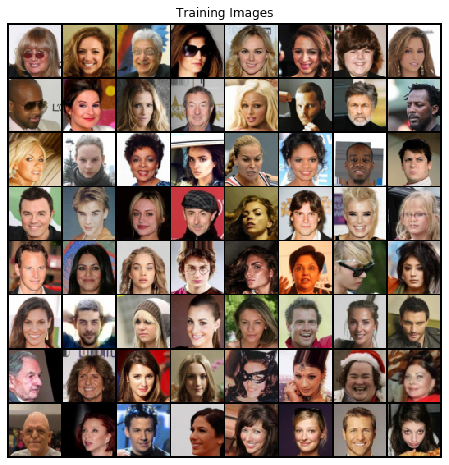

･ RAM:  △Consumed    △Peaked    Used Total | Exec time 0:00:04.640
･ CPU:         36         28        972 MB |
･ GPU:         -8         14      2,237 MB |


In [3]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [4]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

･ RAM:  △Consumed    △Peaked    Used Total | Exec time 0:00:00.002
･ CPU:          0          0        973 MB |
･ GPU:          0          0      2,237 MB |


In [5]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

･ RAM:  △Consumed    △Peaked    Used Total | Exec time 0:00:00.003
･ CPU:          0          0        973 MB |
･ GPU:          0          0      2,237 MB |


In [6]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [7]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

･ RAM:  △Consumed    △Peaked    Used Total | Exec time 0:00:00.004
･ CPU:          0          0        974 MB |
･ GPU:          0          0      2,259 MB |


In [8]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)
･ RAM:  △Consumed    △Peaked  

In [9]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

･ RAM:  △Consumed    △Peaked    Used Total | Exec time 0:00:00.002
･ CPU:          0          0        974 MB |
･ GPU:          0          0      2,279 MB |


In [10]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...


..\aten\src\ATen\native\TensorFactories.cpp:361: UserWarning: Deprecation warning: In a future PyTorch release torch.full will no longer return tensors of floating dtype by default. Instead, a bool fill_value will return a tensor of torch.bool dtype, and an integral fill_value will return a tensor of torch.long dtype. Set the optional `dtype` or `out` arguments to suppress this warning.


[0/5][0/3166]	Loss_D: 2.0226	Loss_G: 4.1323	D(x): 0.3686	D(G(z)): 0.4997 / 0.0214
[0/5][50/3166]	Loss_D: 0.1448	Loss_G: 8.2692	D(x): 0.9266	D(G(z)): 0.0086 / 0.0006
[0/5][100/3166]	Loss_D: 0.5179	Loss_G: 13.6040	D(x): 0.8113	D(G(z)): 0.0003 / 0.0000
[0/5][150/3166]	Loss_D: 0.2126	Loss_G: 5.6216	D(x): 0.8856	D(G(z)): 0.0521 / 0.0077
[0/5][200/3166]	Loss_D: 2.0148	Loss_G: 6.9474	D(x): 0.3533	D(G(z)): 0.0002 / 0.0027
[0/5][250/3166]	Loss_D: 1.9212	Loss_G: 8.7149	D(x): 0.9763	D(G(z)): 0.7699 / 0.0005
[0/5][300/3166]	Loss_D: 0.5220	Loss_G: 3.7588	D(x): 0.7925	D(G(z)): 0.2064 / 0.0387
[0/5][350/3166]	Loss_D: 5.3944	Loss_G: 7.0204	D(x): 0.0298	D(G(z)): 0.0001 / 0.0028
[0/5][400/3166]	Loss_D: 0.6525	Loss_G: 5.5004	D(x): 0.9152	D(G(z)): 0.3612 / 0.0085
[0/5][450/3166]	Loss_D: 1.2760	Loss_G: 8.9808	D(x): 0.9681	D(G(z)): 0.5953 / 0.0007
[0/5][500/3166]	Loss_D: 0.5697	Loss_G: 5.6154	D(x): 0.8095	D(G(z)): 0.2225 / 0.0089
[0/5][550/3166]	Loss_D: 0.6173	Loss_G: 3.9232	D(x): 0.7723	D(G(z)): 0.2045 / 0

[1/5][1650/3166]	Loss_D: 0.5173	Loss_G: 1.5532	D(x): 0.7198	D(G(z)): 0.1262 / 0.2490
[1/5][1700/3166]	Loss_D: 0.5607	Loss_G: 3.1949	D(x): 0.8672	D(G(z)): 0.3099 / 0.0574
[1/5][1750/3166]	Loss_D: 0.7137	Loss_G: 3.7118	D(x): 0.8238	D(G(z)): 0.3596 / 0.0326
[1/5][1800/3166]	Loss_D: 0.5239	Loss_G: 2.7858	D(x): 0.8012	D(G(z)): 0.2266 / 0.0787
[1/5][1850/3166]	Loss_D: 0.9520	Loss_G: 1.3350	D(x): 0.5094	D(G(z)): 0.1130 / 0.3326
[1/5][1900/3166]	Loss_D: 0.4779	Loss_G: 3.3748	D(x): 0.8550	D(G(z)): 0.2480 / 0.0453
[1/5][1950/3166]	Loss_D: 1.0699	Loss_G: 4.1821	D(x): 0.8819	D(G(z)): 0.5214 / 0.0291
[1/5][2000/3166]	Loss_D: 0.4829	Loss_G: 2.6212	D(x): 0.7278	D(G(z)): 0.1148 / 0.0941
[1/5][2050/3166]	Loss_D: 0.8651	Loss_G: 0.7934	D(x): 0.5840	D(G(z)): 0.1776 / 0.4976
[1/5][2100/3166]	Loss_D: 0.6575	Loss_G: 1.9995	D(x): 0.7244	D(G(z)): 0.2278 / 0.1711
[1/5][2150/3166]	Loss_D: 0.5559	Loss_G: 2.1876	D(x): 0.7353	D(G(z)): 0.1657 / 0.1410
[1/5][2200/3166]	Loss_D: 0.5496	Loss_G: 2.8678	D(x): 0.8808	D(G(z

[3/5][100/3166]	Loss_D: 0.4853	Loss_G: 2.3167	D(x): 0.8090	D(G(z)): 0.1983 / 0.1257
[3/5][150/3166]	Loss_D: 0.4687	Loss_G: 2.3516	D(x): 0.7559	D(G(z)): 0.1443 / 0.1172
[3/5][200/3166]	Loss_D: 0.6992	Loss_G: 4.0732	D(x): 0.9525	D(G(z)): 0.4213 / 0.0303
[3/5][250/3166]	Loss_D: 1.0849	Loss_G: 5.3373	D(x): 0.9551	D(G(z)): 0.5857 / 0.0073
[3/5][300/3166]	Loss_D: 2.4893	Loss_G: 6.1824	D(x): 0.9268	D(G(z)): 0.8104 / 0.0067
[3/5][350/3166]	Loss_D: 0.7271	Loss_G: 1.5504	D(x): 0.5877	D(G(z)): 0.0990 / 0.2659
[3/5][400/3166]	Loss_D: 0.5367	Loss_G: 1.9035	D(x): 0.7191	D(G(z)): 0.1472 / 0.1883
[3/5][450/3166]	Loss_D: 0.4873	Loss_G: 2.0059	D(x): 0.7095	D(G(z)): 0.0894 / 0.1752
[3/5][500/3166]	Loss_D: 1.4005	Loss_G: 6.2040	D(x): 0.9800	D(G(z)): 0.6811 / 0.0043
[3/5][550/3166]	Loss_D: 0.4338	Loss_G: 2.6501	D(x): 0.7432	D(G(z)): 0.0952 / 0.0989
[3/5][600/3166]	Loss_D: 1.2465	Loss_G: 5.0883	D(x): 0.9119	D(G(z)): 0.5951 / 0.0100
[3/5][650/3166]	Loss_D: 0.7262	Loss_G: 2.7510	D(x): 0.7614	D(G(z)): 0.3105 /

[4/5][1750/3166]	Loss_D: 0.6408	Loss_G: 1.9452	D(x): 0.6303	D(G(z)): 0.0655 / 0.1883
[4/5][1800/3166]	Loss_D: 0.4406	Loss_G: 2.5173	D(x): 0.8059	D(G(z)): 0.1668 / 0.1043
[4/5][1850/3166]	Loss_D: 0.8235	Loss_G: 2.0046	D(x): 0.8061	D(G(z)): 0.3828 / 0.1755
[4/5][1900/3166]	Loss_D: 0.3975	Loss_G: 3.0917	D(x): 0.8338	D(G(z)): 0.1652 / 0.0626
[4/5][1950/3166]	Loss_D: 1.4305	Loss_G: 1.9447	D(x): 0.3763	D(G(z)): 0.0716 / 0.2506
[4/5][2000/3166]	Loss_D: 0.4775	Loss_G: 2.3304	D(x): 0.7310	D(G(z)): 0.1120 / 0.1302
[4/5][2050/3166]	Loss_D: 0.3606	Loss_G: 2.7737	D(x): 0.8557	D(G(z)): 0.1587 / 0.0875
[4/5][2100/3166]	Loss_D: 0.5299	Loss_G: 3.6958	D(x): 0.8234	D(G(z)): 0.2402 / 0.0360
[4/5][2150/3166]	Loss_D: 0.5580	Loss_G: 1.5005	D(x): 0.6317	D(G(z)): 0.0434 / 0.2717
[4/5][2200/3166]	Loss_D: 0.4701	Loss_G: 3.7637	D(x): 0.8614	D(G(z)): 0.2442 / 0.0325
[4/5][2250/3166]	Loss_D: 0.6998	Loss_G: 1.2235	D(x): 0.6300	D(G(z)): 0.1355 / 0.3465
[4/5][2300/3166]	Loss_D: 0.8022	Loss_G: 1.4035	D(x): 0.5344	D(G(z

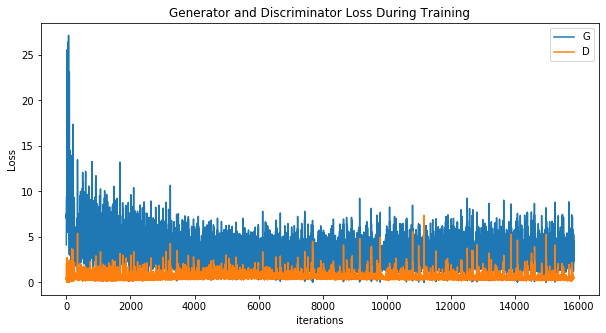

･ RAM:  △Consumed    △Peaked    Used Total | Exec time 0:00:00.238
･ CPU:          0          3      1,941 MB |
･ GPU:          0          0      4,291 MB |


In [11]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

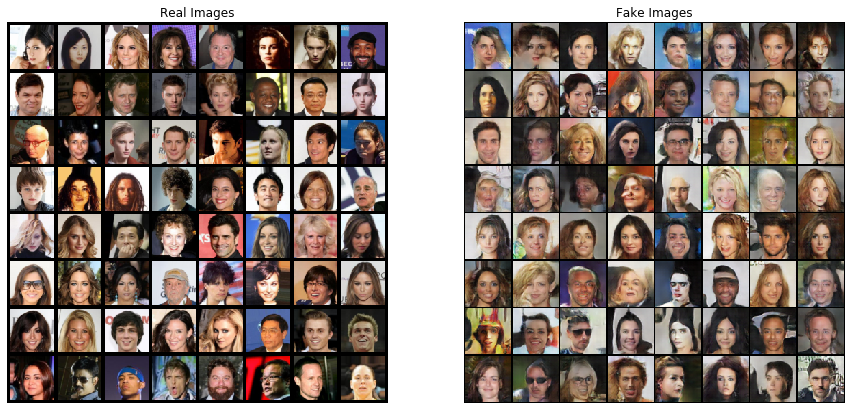

･ RAM:  △Consumed    △Peaked    Used Total | Exec time 0:00:03.494
･ CPU:          0         32      1,942 MB |
･ GPU:          0          0      4,291 MB |


In [12]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()